In [10]:
import base64
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint
import json
import seaborn as sns
import re
import os

pp = pprint.PrettyPrinter(indent=4)

df_name = 'experiment_results_prolific_pilot_10ps'

In [31]:
remove_negative_gaze = True
# code CJ45HISW
filter_blacklist = True
filter_timestamps = False

blacklist = ['j']
df = pd.read_csv(f'data/raw_data/{df_name}.csv')
df = df.drop('type', axis=1)

timestamps = ['04-Mar-2025 10:32:34']

if filter_timestamps:
    df = df[~df['timestamp'].isin(timestamps)]

if filter_blacklist:
    df = df[~df['workerid'].isin(blacklist)]

# reindex the df
df.reset_index(drop=True, inplace=True)

def parse(data):
    while data[0] != '{':
        data = data[1:]
    while data[-1] != '}':
        data = data[:-1]
    data = data.replace('\\', '')
    data = re.sub(
        r'(?<=strategy":")(.*)(?="\})',
        lambda m: m.group(0).replace('"', '\\"'),
        data,
        count=1)
    json_data = {}
    try:
        json_data = json.loads(data)
    except:
        pp.pprint(data[-200:])
    return json_data

df = pd.concat([df, pd.json_normalize(df.apply(lambda x: parse(x['answer']), axis=1, ), max_level=0)], axis=1)

if remove_negative_gaze:
    df.gaze = df.gaze.apply(lambda x: {key:val for key, val in json.loads(base64.b64decode(x)).items() if int(key) > 0 and val['x'] is not None})
else:
    df.gaze = df.gaze.apply(lambda x: {key:val for key, val in json.loads(base64.b64decode(x)).items() if val['x'] is not None})
df.sort_values(by=['workerid', 'userTrialId'], inplace=True)
df.reset_index(drop=True, inplace=True)
df['deviceInfo'] = df['deviceInfo'].ffill()
df.columns

Index(['filename', 'listnumber', 'assignmentid', 'hitid', 'workerid', 'origin',
       'timestamp', 'partid', 'questionid', 'answer', 'trialid', 'sentmsg',
       'trgt', 'comp', 'dist', 'msg1', 'msg2', 'msg3', 'msg4', 'id',
       'sent_msg', 'objs', 'trgtPos', 'compPos', 'distPos', 'type',
       'msgsOrder', 'userTrialId', 'answerTime', 'choicePos', 'choice',
       'coordinates', 'gaze', 'correct', 'deviceInfo', 'calibrationPrecision',
       'techDiffs', 'otherComments', 'strategy'],
      dtype='object')

In [14]:
for id in df['workerid'].unique():
    print(f'{id}, ')

5ed367525fe8eb2fa817b9c1, 
6037919c2b5de32d6ebaee90, 
60bf706fc3b12a3c4f11a487, 
661e75b62240d5ad7b18a9a6, 
665d5a08c8e61c18498d08c9, 
66855ff6755a311dada39b28, 
671a528fe9658f0a32bd55ce, 
676700ebaf4a1fdf1868d7c6, 
676942464fe51377822349c7, 
677dc096791809f5e6c196a9, 


In [27]:
df = df[df['workerid'] == '677dc096791809f5e6c196a9']


### Convert Gaze to Fixation detection format
#### After consideration, fixation detection does not seem like a good choice for our data

In [13]:
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# for participant in df['workerid'].unique():
#     participant_df = df[df['workerid'] == participant]
#     participant_df.reset_index(drop=True, inplace=True)
#     x = participant_df['gaze'].apply(lambda gaze: [gaze[key]['x'] for key in gaze.keys()])
#     y = participant_df['gaze'].apply(lambda gaze: [gaze[key]['y'] for key in gaze.keys()])
#     time = participant_df['gaze'].apply(lambda gaze: [int(key) for key in gaze.keys()])
#     # shift all values to remove negative values
#     time = time.apply(lambda x: [i - min(x) for i in x])
#     prep_df = pd.DataFrame({'trial': participant_df['userTrialId'],'x': x, 'y': y, 'time': time})
#     prep_df = prep_df.explode(['x','y','time'])
#     prep_df.sort_values(by=['trial', 'time'], inplace=True)
#     prep_df.to_csv(f'data/participants_raw_gaze/{participant}.csv', index=False)

# import subprocess
# subprocess.call("/usr/bin/Rscript --vanilla ~/uds/thesis/Thesis-Project/analysis/fixations.r", shell=True)

# for participant in df['workerid'].unique():
#     participant_fixations = pd.read_csv(f'data/participants_fixations/{participant}.csv')

#     fixations = participant_fixations.groupby('trial').apply(lambda x: x.to_dict(orient='records')).to_dict()
#     print(fixations)
#     df.loc[df['workerid'] == participant, 'fixations'] = df[df['workerid'] == participant]['userTrialId'].apply(lambda x: fixations[x] if x in fixations else [])
    

## Gen Features

In [32]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

df['meanAnswerTime'] = df.groupby('workerid')['answerTime'].transform('mean')
df['answerAccuracy'] = df.groupby('workerid')['correct'].transform('mean')
df['answerAccuracySimple'] = df[df['type'].isin(['simple','strategy_simple'])].groupby('workerid')['correct'].transform('mean')
df['answerAccuracyComplex'] = df[df['type'].isin(['complex', 'strategy_complex'])].groupby('workerid')['correct'].transform('mean')
df['answerAccuracyUnambiguous'] = df[df['type'] == 'unambiguous'].groupby('workerid')['correct'].transform('mean')
df['resolution'] = df.deviceInfo.apply(lambda x: [int(size) for size in x['screen'].split('x')])

def compute_polygon(polygon_type, coords):
    x12 = (coords['img1']['x'] + coords['img1']['width'] + coords['img2']['x'])/2
    x23 = (coords['img2']['x'] + coords['img2']['width'] + coords['img3']['x'])/2
    y12 = (coords['sent_msg']['y'] + coords['sent_msg']['height'] + coords['img1']['y'])/2
    y23 = (coords['img1']['y'] + coords['img1']['height'] + coords['available_msgs']['y'])/2
    match polygon_type:
        case 'sent_msg':
            return Polygon([(x23+x12/2, 0), (x12/2, 0), (x12, y12), (x23, y12)])
        case 'img1':
            return Polygon([(0, y12/2), (x12, y12), (x12, y23), (0, y23+y12/2)])
        case 'img2':
            return Polygon([(x12, y12), (x23, y12), (x23, y23), (x12, y23)])
        case 'img3':
            return Polygon([(x23, y12), (x12+x23, y12/2), (x12+x23, y23+y12/2), (x23, y23)])
        case 'available_msgs':
            return Polygon([(x12, y23), (x23, y23), (x23+x12/2, y12+y23), (x12/2, y12+y23)])


def count_gaze(gaze, polygon, participant=None):
    count = 0
    # check if there is gaze is not empty
    if not gaze:
        return 0
    for _, val in gaze.items():
        point = Point(val['x'], val['y'])
        if polygon.contains(point):
            count += 1
    return count

def merge_msgs_coords(coords):
    coords['available_msgs'] = {'height': coords['msg1']['height'], 'width': coords['msg4']['x'] + coords['msg4']['width'] - coords['msg1']['x'], 'x': coords['msg1']['x'], 'y': coords['msg1']['y']}
    return coords

df['coordinates'] = df.apply(lambda x: merge_msgs_coords(x['coordinates']), axis=1)
df['timeOnSentMsg'] = df.apply(lambda x: count_gaze(x['gaze'], compute_polygon('sent_msg', x['coordinates']), x['workerid']), axis=1) 
df['timeOnSentMsgSimple'] = df[df['type'].isin(['simple','strategy_simple'])].apply(lambda x: x['timeOnSentMsg'], axis=1)
df['timeOnSentMsgComplex'] = df[df['type'].isin(['complex', 'strategy_complex'])].apply(lambda x: x['timeOnSentMsg'], axis=1)
df['timeOnSentMsgUnambiguous'] = df[df['type'] == 'unambiguous'].apply(lambda x: x['timeOnSentMsg'], axis=1)
df['timeOnAvailableMsgs'] = df.apply(lambda x: count_gaze(x['gaze'], compute_polygon('available_msgs', x['coordinates'])), axis=1)
df['timeOnAvailableMsgsSimple'] = df[df['type'].isin(['simple','strategy_simple'])].apply(lambda x: x['timeOnAvailableMsgs'], axis=1)
df['timeOnAvailableMsgsComplex'] = df[df['type'].isin(['complex', 'strategy_complex'])].apply(lambda x: x['timeOnAvailableMsgs'], axis=1)
df['timeOnAvailableMsgsUnambiguous'] = df[df['type'] == 'unambiguous'].apply(lambda x: x['timeOnAvailableMsgs'], axis=1)
df['timeOnImg1'] = df.apply(lambda x: count_gaze(x['gaze'], compute_polygon('img1', x['coordinates'])), axis=1)
df['timeOnImg2'] = df.apply(lambda x: count_gaze(x['gaze'], compute_polygon('img2', x['coordinates'])), axis=1)
df['timeOnImg3'] = df.apply(lambda x: count_gaze(x['gaze'], compute_polygon('img3', x['coordinates'])), axis=1)
df['timeOnTrgt'] = df.apply(lambda x: x[('timeOnImg' + str(1 + x['trgtPos']))], axis=1)
df['timeOnTrgtSimple'] = df[df['type'].isin(['simple','strategy_simple'])].apply(lambda x: x[('timeOnImg' + str(1 + x['trgtPos']))], axis=1)
df['timeOnTrgtComplex'] = df[df['type'].isin(['complex', 'strategy_complex'])].apply(lambda x: x[('timeOnImg' + str(1 + x['trgtPos']))], axis=1)
df['timeOnTrgtUnambiguous'] = df[df['type'] == 'unambiguous'].apply(lambda x: x[('timeOnImg' + str(1 + x['trgtPos']))], axis=1)
df['timeOnDist'] = df.apply(lambda x: x[('timeOnImg' + str(1 + x['distPos']))], axis=1)
df['timeOnDistSimple'] = df[df['type'].isin(['simple','strategy_simple'])].apply(lambda x: x[('timeOnImg' + str(1 + x['distPos']))], axis=1)
df['timeOnDistComplex'] = df[df['type'].isin(['complex', 'strategy_complex'])].apply(lambda x: x[('timeOnImg' + str(1 + x['distPos']))], axis=1)
df['timeOnDistUnambiguous'] = df[df['type'] == 'unambiguous'].apply(lambda x: x[('timeOnImg' + str(1 + x['distPos']))], axis=1)
df['timeOnComp'] = df.apply(lambda x: x[('timeOnImg' + str(1 + x['compPos']))], axis=1)
df['timeOnCompSimple'] = df[df['type'].isin(['simple','strategy_simple'])].apply(lambda x: x[('timeOnImg' + str(1 + x['compPos']))], axis=1)
df['timeOnCompComplex'] = df[df['type'].isin(['complex', 'strategy_complex'])].apply(lambda x: x[('timeOnImg' + str(1 + x['compPos']))], axis=1)
df['timeOnCompUnambiguous'] = df[df['type'] == 'unambiguous'].apply(lambda x: x[('timeOnImg' + str(1 + x['compPos']))], axis=1)
df['timeOnAOI'] = df.apply(lambda x: sum(x[['timeOnSentMsg', 'timeOnAvailableMsgs', 'timeOnImg1', 'timeOnImg2', 'timeOnImg3']]), axis=1)
df['timeOnTrial'] = df.apply(lambda x: len(x['gaze']), axis=1)
df['timeOnNonAOI'] = df.apply(lambda x: x['timeOnTrial'] - x['timeOnAOI'], axis=1)
df['timeOnNonAOISimple'] = df.apply(lambda x: x['timeOnTrial'] - sum(x[['timeOnSentMsgSimple', 'timeOnAvailableMsgsSimple', 'timeOnTrgtSimple', 'timeOnCompSimple', 'timeOnDistSimple']]), axis=1)
df['timeOnNonAOIComplex'] = df.apply(lambda x: x['timeOnTrial'] - sum(x[['timeOnSentMsgComplex', 'timeOnAvailableMsgsComplex', 'timeOnTrgtComplex', 'timeOnCompComplex', 'timeOnDistComplex']]), axis=1)
df['timeOnNonAOIUnambiguous'] = df.apply(lambda x: x['timeOnTrial'] - sum(x[['timeOnSentMsgUnambiguous', 'timeOnAvailableMsgsUnambiguous', 'timeOnTrgtUnambiguous', 'timeOnCompUnambiguous', 'timeOnDistUnambiguous']]), axis=1)
df['propTimeOnNonAOI'] = df['timeOnNonAOI'] / df['timeOnTrial']
df['propTimeOnNonAOISimple'] = df['timeOnNonAOISimple'] / df['timeOnTrial']
df['propTimeOnNonAOIComplex'] = df['timeOnNonAOIComplex'] / df['timeOnTrial']
df['propTimeOnNonAOIUnambiguous'] = df['timeOnNonAOIUnambiguous'] / df['timeOnTrial']
df['propTimeOnSentMsg'] = df['timeOnSentMsg'] / df['timeOnTrial']
df['propTimeOnSentMsgSimple'] = df['timeOnSentMsgSimple'] / df['timeOnTrial']
df['propTimeOnSentMsgComplex'] = df['timeOnSentMsgComplex'] / df['timeOnTrial']
df['propTimeOnSentMsgUnambiguous'] = df['timeOnSentMsgUnambiguous'] / df['timeOnTrial']
df['propTimeOnAvailableMsgs'] = df['timeOnAvailableMsgs'] / df['timeOnTrial']
df['propTimeOnAvailableMsgsSimple'] = df['timeOnAvailableMsgsSimple'] / df['timeOnTrial']
df['propTimeOnAvailableMsgsComplex'] = df['timeOnAvailableMsgsComplex'] / df['timeOnTrial']
df['propTimeOnAvailableMsgsUnambiguous'] = df['timeOnAvailableMsgsUnambiguous'] / df['timeOnTrial']
df['propTimeOnTrgt'] = df['timeOnTrgt'] / df['timeOnTrial']
df['propTimeOnTrgtSimple'] = df['timeOnTrgtSimple'] / df['timeOnTrial']
df['propTimeOnTrgtComplex'] = df['timeOnTrgtComplex'] / df['timeOnTrial']
df['propTimeOnTrgtUnambiguous'] = df['timeOnTrgtUnambiguous'] / df['timeOnTrial']
df['propTimeOnDist'] = df['timeOnDist'] / df['timeOnTrial']
df['propTimeOnDistSimple'] = df['timeOnDistSimple'] / df['timeOnTrial']
df['propTimeOnDistComplex'] = df['timeOnDistComplex'] / df['timeOnTrial']
df['propTimeOnDistUnambiguous'] = df['timeOnDistUnambiguous'] / df['timeOnTrial']
df['propTimeOnComp'] = df['timeOnComp'] / df['timeOnTrial']
df['propTimeOnCompSimple'] = df['timeOnCompSimple'] / df['timeOnTrial']
df['propTimeOnCompComplex'] = df['timeOnCompComplex'] / df['timeOnTrial']
df['propTimeOnCompUnambiguous'] = df['timeOnCompUnambiguous'] / df['timeOnTrial']

msg_type = {'ci': 'shape',
            'sq': 'shape',
            'tr': 'shape',
            'bl': 'color',
            're': 'color',
            'gr': 'color'}
df['msgType'] = df['sent_msg'].map(msg_type)

df['condition'] = df['type'].map({'simple': 'simple', 'complex': 'complex', 'strategy_simple': 'simple', 'strategy_complex': 'complex', 'unambiguous': 'unambiguous'})

df['gaze'] = df['gaze'].apply(lambda x: json.dumps(x))
df['coordinates'] = df['coordinates'].apply(lambda x: json.dumps(x))
df.to_csv(f'data/preprocessed_data/{df_name}.csv', index=False)

df['gaze'] = df['gaze'].apply(lambda x: json.loads(x))
df['coordinates'] = df['coordinates'].apply(lambda x: json.loads(x))

In [40]:
df[['workerid', 'answerAccuracySimple', 'answerAccuracyComplex', 'answerAccuracyUnambiguous']].drop_duplicates()

,workerid,answerAccuracySimple,answerAccuracyComplex,answerAccuracyUnambiguous
0,5ed367525fe8eb2fa817b9c1,1.000000,NaN,NaN
2,5ed367525fe8eb2fa817b9c1,NaN,NaN,1.000000
3,5ed367525fe8eb2fa817b9c1,NaN,0.769231,NaN
38,6037919c2b5de32d6ebaee90,1.000000,NaN,NaN
40,6037919c2b5de32d6ebaee90,NaN,NaN,1.000000
42,6037919c2b5de32d6ebaee90,NaN,0.615385,NaN
76,60bf706fc3b12a3c4f11a487,0.692308,NaN,NaN
77,60bf706fc3b12a3c4f11a487,NaN,0.615385,NaN
80,60bf706fc3b12a3c4f11a487,NaN,NaN,1.000000
114,661e75b62240d5ad7b18a9a6,NaN,NaN,1.000000


## Explode Gaze and Create CSV

In [6]:
gaze_df = df[['workerid', 'userTrialId', 'type', 'correct', 'answerTime', 'gaze', 'trgtPos', 'distPos', 'compPos', 'coordinates', 'condition', 'msgType']]

def detect_aoi(point, coords):
    for aoi in ['sent_msg', 'img1', 'img2', 'img3', 'available_msgs']:
        polygon = compute_polygon(aoi, coords)
        if polygon.contains(point):
            return aoi
    return 'non_aoi'

def explode_gaze(row):
    x = []
    y = []
    time = []
    aois = []
    subject = row['workerid']
    trial = row['userTrialId']
    condition = row['type']
    msg_type = row['msgType']
    trgt_pos = row['trgtPos']
    for key, val in row['gaze'].items():
        x.append(val['x'])
        y.append(val['y'])
        time.append(int(key))
        point = Point(val['x'], val['y'])
        img_to_obj = {row['trgtPos'] : 'trgt', row['distPos'] : 'dist', row['compPos'] : 'comp'}
        aoi = detect_aoi(point, row['coordinates'])
        if aoi in ['img1', 'img2', 'img3']:
            aoi = img_to_obj[int(aoi[-1])-1]
        aois.append(aoi)
    return pd.DataFrame({'Subject': subject, 'Trial': trial, 'Condition': condition, 'MsgType': msg_type, 'TrgtPos': trgt_pos, 'Time': time, 'AOI': aois})
# np.array(gaze_df.apply(lambda x: explode_gaze(x), axis=1)).flatten()
pd.concat(np.array(gaze_df.apply(lambda x: explode_gaze(x), axis=1)).flatten(), axis=0).to_csv('data/gaze.csv', index=False)

# Final Feature CSV per Trial

In [7]:
final_df_features = ['workerid',
                     'userTrialId',
                     'type',
                     'correct',
                     'answerTime',
                     'propTimeOnSentMsg',
                     'propTimeOnTrgt',
                     'propTimeOnDist',
                     'propTimeOnComp',
                     'propTimeOnAvailableMsgs',
                     'propTimeOnNonAOI',
                     'trgtPos',
                     'msgType'
                    ]
final_df = df[final_df_features]
final_df = final_df.rename(columns={'workerid': 'Subject',
                                    'userTrialId': 'Trial',
                                    'type': 'Condition',
                                    'correct': 'Correct',
                                    'answerTime': 'AnswerTime',
                                    'propTimeOnSentMsg': 'PropTimeOnSentMsg',
                                    'propTimeOnTrgt': 'PropTimeOnTrgt',
                                    'propTimeOnDist': 'PropTimeOnDist',
                                    'propTimeOnComp': 'PropTimeOnComp',
                                    'propTimeOnAvailableMsgs': 'PropTimeOnAvailableMsgs',
                                    'propTimeOnNonAOI': 'PropTimeOnNonAOI',
                                    'trgtPos': 'TargetPosition',
                                    'msgType': 'MsgType'})
final_df.to_csv('data/final_trial_df.csv', index=False)
final_df.head()

,Subject,Trial,Condition,Correct,AnswerTime,PropTimeOnSentMsg,PropTimeOnTrgt,PropTimeOnDist,PropTimeOnComp,PropTimeOnAvailableMsgs,PropTimeOnNonAOI,TargetPosition,MsgType
0,iza_test3_11february,0,unambiguous,1,9108,0.059259,0.133333,0.251852,0.251852,0.170370,0.133333,0,shape
1,iza_test3_11february,1,unambiguous,1,2977,0.461538,0.000000,0.230769,0.076923,0.076923,0.153846,0,color
2,iza_test3_11february,2,complex,1,10220,0.026316,0.157895,0.184211,0.184211,0.144737,0.302632,2,color
3,iza_test3_11february,3,complex,1,5943,0.170213,0.085106,0.382979,0.276596,0.000000,0.085106,0,color
4,iza_test3_11february,4,complex,1,13538,0.077922,0.000000,0.000000,0.636364,0.285714,0.000000,2,shape


## Final Feature CSV per Participant

In [42]:
final_df_features = ['propTimeOnSentMsg',
                        'propTimeOnSentMsgSimple',
                        'propTimeOnSentMsgComplex',
                        'propTimeOnSentMsgUnambiguous',
                        'propTimeOnAvailableMsgs',
                        'propTimeOnAvailableMsgsSimple',
                        'propTimeOnAvailableMsgsComplex',
                        'propTimeOnAvailableMsgsUnambiguous',
                        'propTimeOnTrgt',
                        'propTimeOnTrgtSimple',
                        'propTimeOnTrgtComplex',
                        'propTimeOnTrgtUnambiguous',
                        'propTimeOnDist',
                        'propTimeOnDistSimple',
                        'propTimeOnDistComplex',
                        'propTimeOnDistUnambiguous',
                        'propTimeOnComp',
                        'propTimeOnCompSimple',
                        'propTimeOnCompComplex',
                        'propTimeOnCompUnambiguous',
                        'propTimeOnNonAOISimple',
                        'propTimeOnNonAOIComplex',
                        'propTimeOnNonAOIUnambiguous',
                        'meanAnswerTime',
                        'answerAccuracySimple',
                        'answerAccuracyComplex',
                        'answerAccuracyUnambiguous'
                     ]
final_df = df.groupby('workerid')[final_df_features].mean()
final_df['calibrationPrecision'] = df.groupby('workerid')['calibrationPrecision'].first()

# Save the final df
final_df.to_csv('data/final_participant_df.csv')
final_df

,propTimeOnSentMsg,propTimeOnSentMsgSimple,propTimeOnSentMsgComplex,propTimeOnSentMsgUnambiguous,propTimeOnAvailableMsgs,propTimeOnAvailableMsgsSimple,propTimeOnAvailableMsgsComplex,propTimeOnAvailableMsgsUnambiguous,propTimeOnTrgt,propTimeOnTrgtSimple,...,propTimeOnCompComplex,propTimeOnCompUnambiguous,propTimeOnNonAOISimple,propTimeOnNonAOIComplex,propTimeOnNonAOIUnambiguous,meanAnswerTime,answerAccuracySimple,answerAccuracyComplex,answerAccuracyUnambiguous,calibrationPrecision
workerid,,,,,,,,,,,,,,,,,,,,,
5ed367525fe8eb2fa817b9c1,0.389265,0.279539,0.375887,0.522629,0.010770,0.020043,0.009125,0.002506,0.211014,0.217802,...,0.062862,0.129825,0.037593,0.028696,0.055159,6825.736842,1.000000,0.769231,1.000000,"[88, 69, 72]"
6037919c2b5de32d6ebaee90,0.470491,0.406965,0.332251,0.689071,0.051913,0.023638,0.118492,0.010417,0.186670,0.225368,...,0.095891,0.046875,0.024701,0.002137,0.031061,4130.026316,1.000000,0.615385,1.000000,"[76, 67, 75]"
60bf706fc3b12a3c4f11a487,0.430782,0.322380,0.405918,0.575153,0.098987,0.147209,0.111369,0.033333,0.176060,0.205961,...,0.188704,0.068863,0.061605,0.020348,0.005405,3390.552632,0.692308,0.615385,1.000000,"[83, 78, 65]"
661e75b62240d5ad7b18a9a6,0.348704,0.374370,0.271413,0.404630,0.044525,0.026688,0.091224,0.013260,0.212276,0.088844,...,0.078444,0.144590,0.014826,0.020698,0.071957,3344.184211,0.846154,0.692308,1.000000,"[65, 87, 82]"
665d5a08c8e61c18498d08c9,0.333886,0.407390,0.160005,0.442628,0.043005,0.082205,0.043503,0.000000,0.177844,0.182056,...,0.298852,0.377244,0.011282,0.012587,0.026709,4285.578947,0.923077,0.538462,1.000000,"[73, 73, 72]"
66855ff6755a311dada39b28,0.355640,0.279749,0.167523,0.641649,0.052337,0.049564,0.103421,0.000000,0.138547,0.186518,...,0.206051,0.073159,0.062017,0.028889,0.020688,6799.552632,1.000000,0.923077,1.000000,"[74, 71, 80]"
671a528fe9658f0a32bd55ce,0.314207,0.291301,0.167790,0.497641,0.178599,0.200424,0.314731,0.007479,0.155064,0.191464,...,0.203075,0.206540,0.049559,0.087027,0.012236,6399.842105,1.000000,0.923077,1.000000,"[84, 72, 68]"
676700ebaf4a1fdf1868d7c6,0.425300,0.444227,0.376512,0.457648,0.030462,0.007343,0.051670,0.032531,0.228096,0.250283,...,0.178607,0.051089,0.013316,0.023612,0.050782,5897.210526,0.692308,0.692308,0.916667,"[78, 91, 73]"
676942464fe51377822349c7,0.309567,0.413118,0.193589,0.323031,0.070552,0.073124,0.062470,0.076523,0.175284,0.235087,...,0.166958,0.236518,0.003973,0.019943,0.124418,14601.052632,0.769231,0.461538,0.916667,"[78, 69, 80]"


### Fitting Some Regressions

[0.73932876 0.09287049 0.06902342 0.04614951 0.03279965 0.01982818]


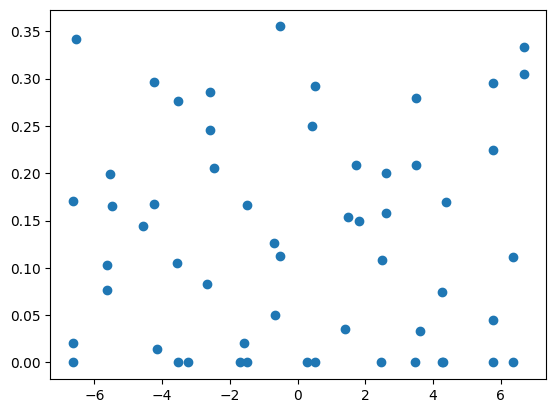

In [10]:
import math

def logit(x):
    odds = x/(1-x)
    if (x/1-x) >= 1:
        odds -= 1e-10
    elif (x/1-x) <= 0:
        odds += 1e-9
    return math.log(odds)

fit_df = pd.read_csv('data/final_trial_df.csv')


features = ['TrgtPosLeftRight', 'TrgtPosMiddle', 'Trial', 'MsgColorShape', 'SimpleComplex', 'Unambiguous']
# code 3 conditions into 2 columns of binary values

code = [[ 1, -1],
        [-1, -1],
        [ 0,  2]]

simple_vs_complex = {'simple': 1, 'complex': -1, 'unambiguous': 0, 'strategy_simple': 1, 'strategy_complex': -1}
left_vs_right = [1, 0, -1]
color_vs_shape = {'color': 1, 'shape': -1}
fit_df['TrgtPosLeftRight'] = fit_df['TargetPosition'].apply(lambda x: left_vs_right[x])
fit_df['TrgtPosMiddle'] = fit_df['TargetPosition'].apply(lambda x: 2 if x == 1 else -1)
fit_df['MsgColorShape'] = fit_df['MsgType'].map(color_vs_shape)
fit_df['SimpleComplex'] = fit_df['Condition'].map(simple_vs_complex)
fit_df['Unambiguous'] = fit_df['Condition'].apply(lambda x: 2 if x == 'unambiguous' else -1)
fit_df['PropTimeOnAvailableMsgsLog'] = fit_df['PropTimeOnAvailableMsgs'].apply(lambda x: logit(x))
fit_df['Trial'] = fit_df['Trial']-fit_df['Trial'].median()

x = fit_df[features]
y = fit_df['PropTimeOnAvailableMsgs']

fit_df[['PropTimeOnAvailableMsgsLog', 'PropTimeOnAvailableMsgs']].head()

# apply pca and report the explained variance
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(x)
explained_variance = pca.explained_variance_ratio_
print(explained_variance)

# plot first principal component against target variable
pca = PCA(n_components=1)
pca.fit(x)
x_pca = pca.transform(x)
plt.scatter(x_pca, y)



In [25]:

# fit linear regression and report correlation of features to target
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x, y)
y_pred = reg.predict(x)

coefs = np.array([features, reg.coef_]).T
print(reg.score(x, y))
print(coefs)

# # plot feature and mmodel predictions for each feature
# for feature in features:
#     plt.figure()
#     sns.scatterplot(x=fit_df[feature], y=fit_df['PropTimeOnAvailableMsgs'])
#     sns.lineplot(x=fit_df[feature], y=y_pred)


0.09889705347121003
[['TrgtPosLeftRight' '0.195964094506491']
 ['TrgtPosMiddle' '0.26409713334823387']
 ['Trial' '-0.07364645705117706']
 ['MsgColorShape' '0.09706406755204097']
 ['SimpleComplex' '-0.3035098453421854']
 ['Unambiguous' '-0.3594961067937925']]


                Subject  Trial    Condition  Correct  AnswerTime  \
0  iza_test3_11february   -6.5  unambiguous        1        9108   
1  iza_test3_11february   -5.5  unambiguous        1        2977   
2  iza_test3_11february   -4.5      complex        1       10220   
3  iza_test3_11february   -3.5      complex        1        5943   
4  iza_test3_11february   -2.5      complex        1       13538   

   PropTimeOnSentMsg  PropTimeOnTrgt  PropTimeOnDist  PropTimeOnComp  \
0           0.059259        0.133333        0.251852        0.251852   
1           0.461538        0.000000        0.230769        0.076923   
2           0.026316        0.157895        0.184211        0.184211   
3           0.170213        0.085106        0.382979        0.276596   
4           0.077922        0.000000        0.000000        0.636364   

   PropTimeOnAvailableMsgs  PropTimeOnNonAOI  TargetPosition MsgType  \
0                 0.170370          0.133333               0   shape   
1             

/home/gatemrou/venvs/ml2024/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/home/gatemrou/venvs/ml2024/lib/python3.12/site-packages/pymer4/models/Lmer.py:744: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_corrs = ran_corrs.applymap(


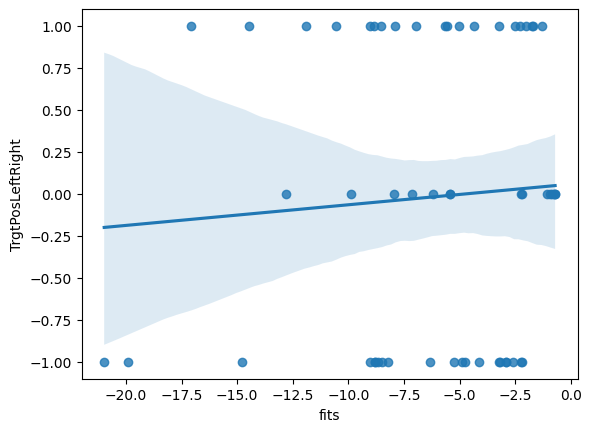

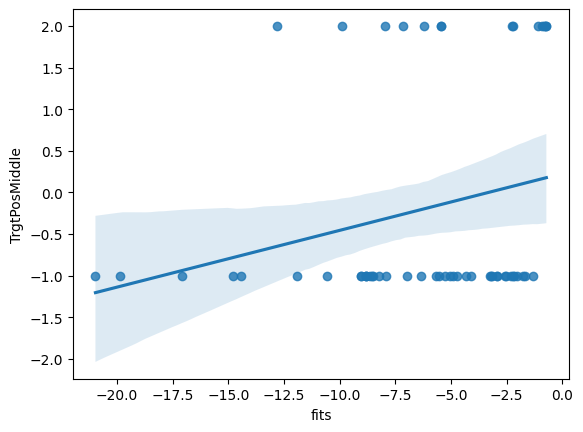

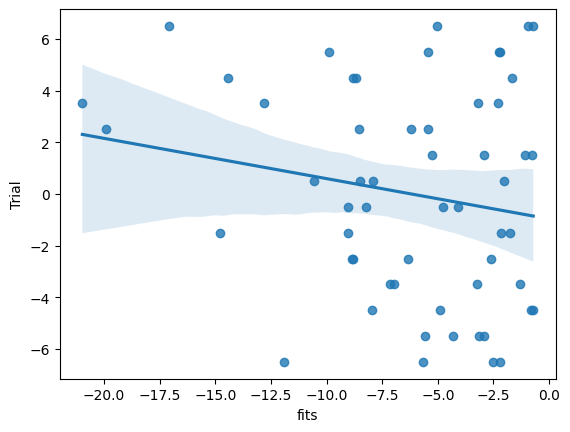

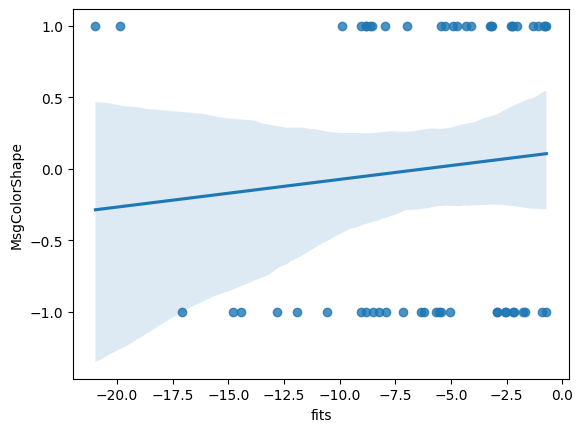

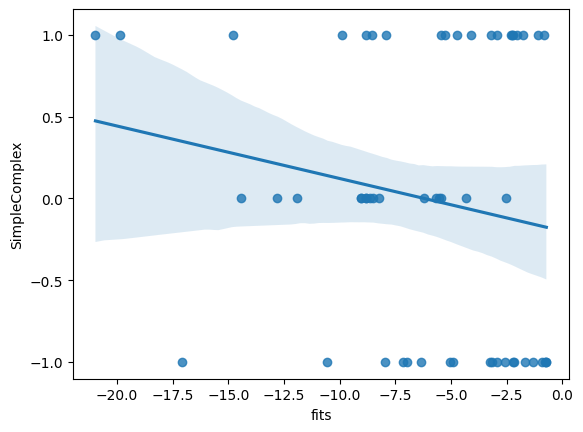

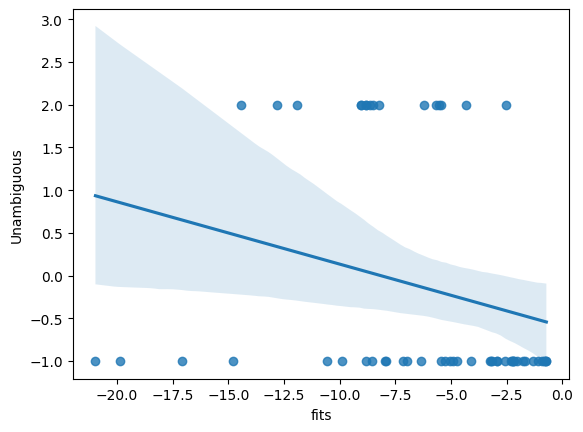

In [ ]:

from pymer4.models import Lmer

print(fit_df.head())
reg = Lmer('PropTimeOnAvailableMsgsLog ~ TrgtPosLeftRight + TrgtPosMiddle + MsgColorShape + SimpleComplex + Unambiguous + Trial + (1 + TrgtPosLeftRight + TrgtPosMiddle + SimpleComplex + Unambiguous + Trial|Subject)', data=fit_df)
print(reg.fit())

# plot feature and model predictions for each feature
for feature in features:
    plt.figure()
    sns.regplot(x='fits', y=feature, data=reg.data, fit_reg=True)



In [19]:
# print(sum([df['propTimeOnNonAOIUnambiguous'].mean(), df['propTimeOnSentMsgUnambiguous'].mean(), df['propTimeOnTrgtUnambiguous'].mean(), df['propTimeOnDistUnambiguous'].mean(), df['propTimeOnCompUnambiguous'].mean()], df['propTimeOnAvailableMsgsUnambiguous'].mean()))
print(df['propTimeOnTrgtComplex'].mean(), df['propTimeOnTrgtSimple'].mean(), df['propTimeOnTrgtUnambiguous'].mean(), df['propTimeOnTrgt'].mean())
# df[['propTimeOnTrgtComplex', 'propTimeOnTrgtSimple', 'propTimeOnTrgtUnambiguous', 'propTimeOnTrgt']]

0.3276323273751244 0.15332341063343208 0.14917432029904992 0.2116451694131535


In [15]:
df = pd.read_csv(f'data/preprocessed_data/{df_name}.csv')
df['coordinates'] = df['coordinates'].apply(lambda x: json.loads(x))
df['gaze'] = df['gaze'].apply(lambda x: json.loads(x))

def gen_plot(workerid, trial_id, gaze, coords, trgt_pos, comp_pos, condition, correct):
    try:
        window_resolution = [coords['img1']['x'] + coords['img3']['x'] + coords['img3']['width'], 
                            2*coords['img1']['y'] + coords['img1']['height']]
    except:
        print(coords)
    imgs = ['img1', 'img2', 'img3', 'sent_msg', 'available_msgs']
    x, y = [], []
    x = np.array([val['x'] for val in gaze.values()])
    y = np.array([val['y'] for val in gaze.values()])
    plt.figure(figsize=(window_resolution[0]*6/window_resolution[1], 6))
    for i in range(len(x)):
        plt.plot(x[i], y[i], color=(0, 0, i/len(x)), marker='o')
    plt.xlim(0, window_resolution[0])
    plt.ylim(0, window_resolution[1])
    for i, area in enumerate(imgs):
        cur_coords = coords[area]
        x_min = max(0, cur_coords['x'])
        x_max = cur_coords['x'] + cur_coords['width']
        y_min = max(0, cur_coords['y'])
        y_max = cur_coords['y'] + cur_coords['height']
        # plot boxes that mark images
        color = (1, 0, 0)
        if trgt_pos == i:
            color = (0, 1, 0)
        elif comp_pos == i:
            color = (1, 1, 0)
        elif area == 'sent_msg':
            color = (0, 1, 1)
        elif area == 'available_msgs':
            color = (1, 0, 1)
        plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], linewidth=3, color=color)
    plt.gca().invert_yaxis()
    plt.axis('off')
    plt.tight_layout()
    os.makedirs(f'data/gaze_plots/pilot/{condition}/{correct}/{workerid}/', exist_ok=True)
    # resize output image to 400x400 before saving
    plt.savefig(f'data/gaze_plots/pilot/{condition}/{correct}/{workerid}/{workerid}_{condition}_{trial_id}_{correct}.png', bbox_inches="tight", transparent=True, pad_inches=0)
    plt.close()

df.apply(lambda x: gen_plot(x['workerid'], x['userTrialId'], x['gaze'], x['coordinates'], x['trgtPos'], x['compPos'], x['condition'], x['correct']), axis=1)


0      None
1      None
2      None
3      None
4      None
       ... 
375    None
376    None
377    None
378    None
379    None
Length: 380, dtype: object

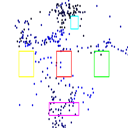

In [ ]:
from PIL import Image

img = Image.open('/home/gatemrou/uds/thesis/Thesis-Project/analysis/data/gaze_plots/tests/complex/0/j/j_complex_1_0.png', 'r')
img.resize((128, 128))

##  Leaderboard

In [45]:
leaderboard_df = df.sort_values(by='meanAnswerTime').sort_values(by='answerAccuracy', ascending=False, kind='stable')[['workerid', 'answerAccuracy', 'meanAnswerTime']].drop_duplicates().reset_index(drop=True)
leaderboard_df.index += 1
pp.pprint(leaderboard_df)

                   workerid  answerAccuracy  meanAnswerTime
1  671a528fe9658f0a32bd55ce        0.973684     6399.842105
2  66855ff6755a311dada39b28        0.973684     6799.552632
3  5ed367525fe8eb2fa817b9c1        0.921053     6825.736842
4  6037919c2b5de32d6ebaee90        0.868421     4130.026316
5  661e75b62240d5ad7b18a9a6        0.842105     3344.184211
6  665d5a08c8e61c18498d08c9        0.815789     4285.578947
7  677dc096791809f5e6c196a9        0.789474     3731.131579
8  60bf706fc3b12a3c4f11a487        0.763158     3390.552632
9  676942464fe51377822349c7        0.710526    14601.052632


677dc096791809f5e6c196a9
{   'browser': 'Chrome',
    'browserMajorVersion': 133,
    'browserVersion': '133.0.0.0',
    'mobile': False,
    'os': 'Windows',
    'osVersion': '10',
    'screen': '1536 x 864'}
[85, 89, 73]
0 complex


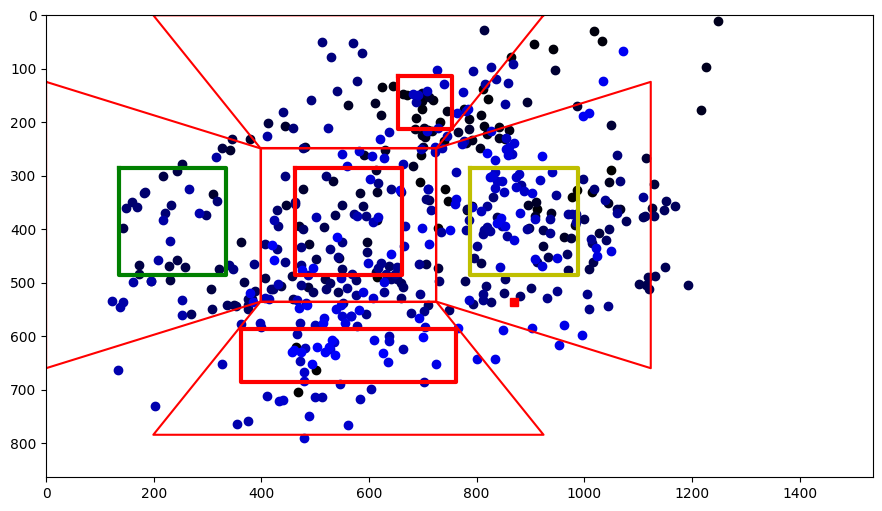

1 complex


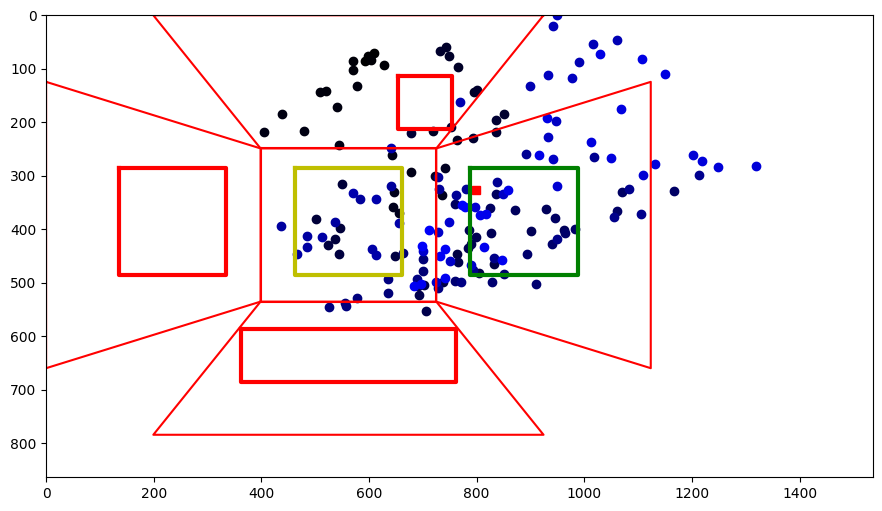

2 simple


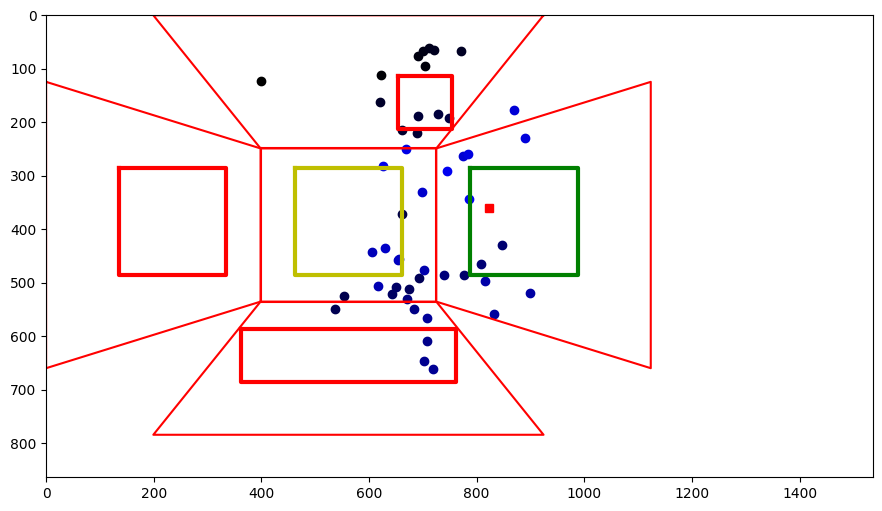

3 unambiguous


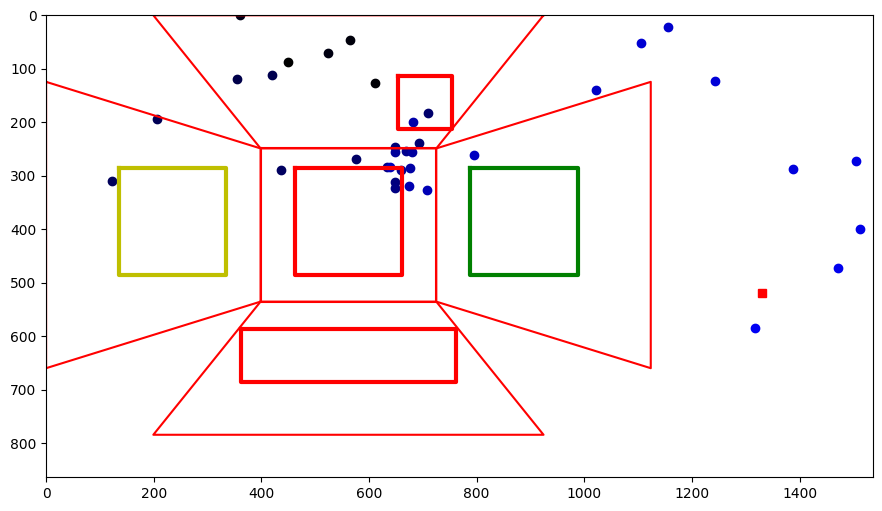

4 complex


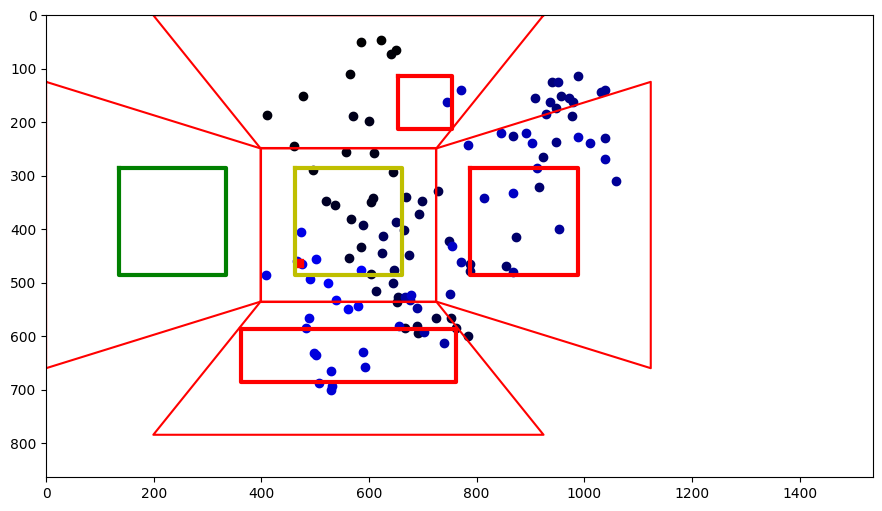

5 unambiguous


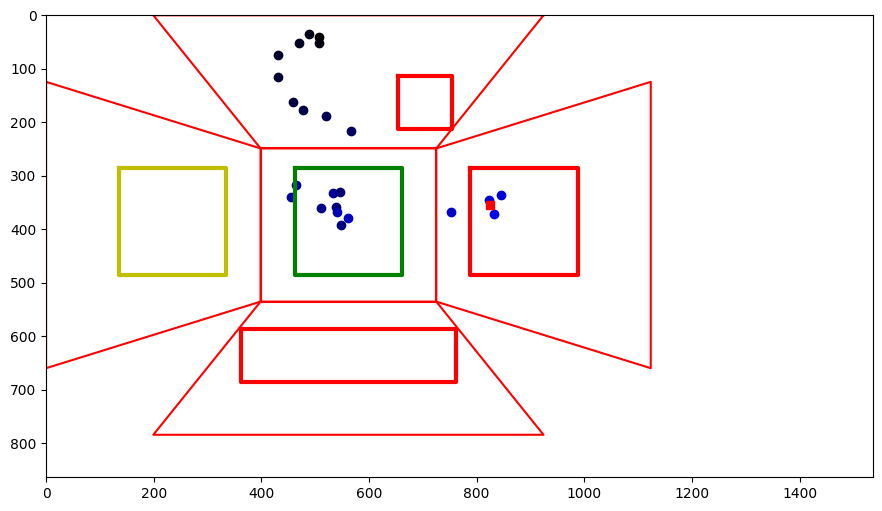

6 simple


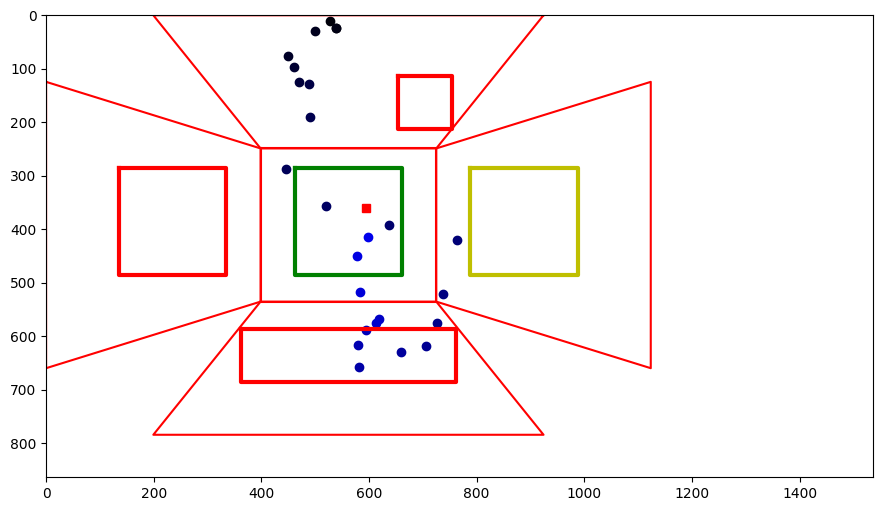

7 simple


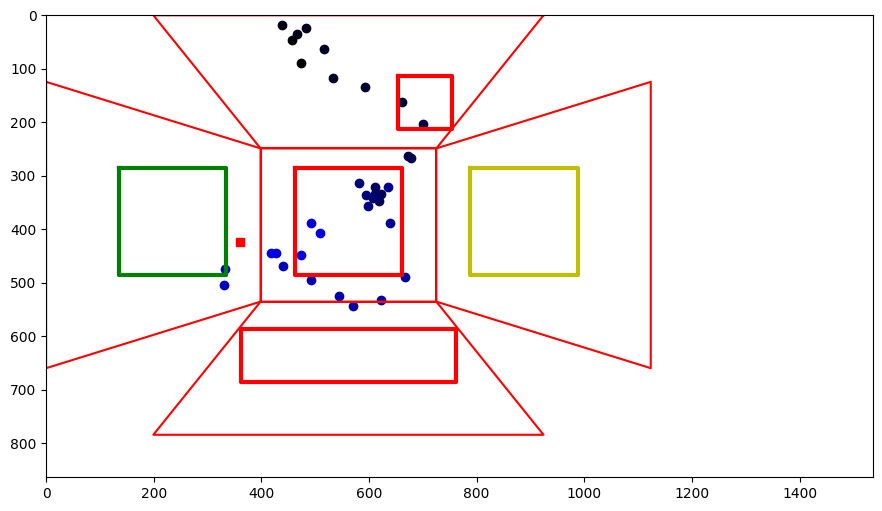

8 unambiguous


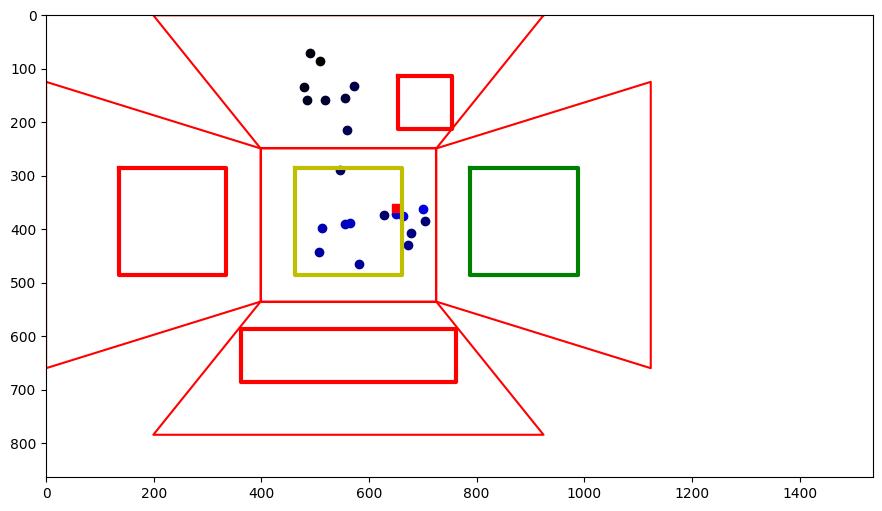

9 unambiguous


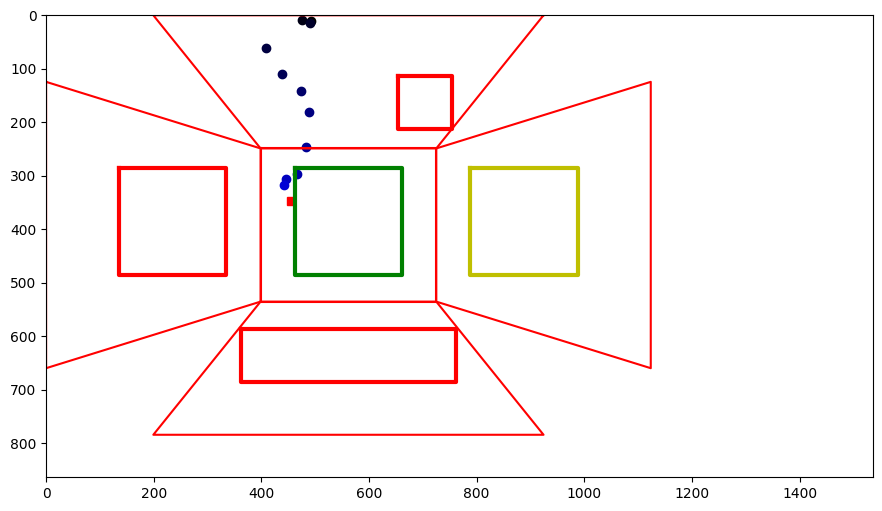

10 unambiguous


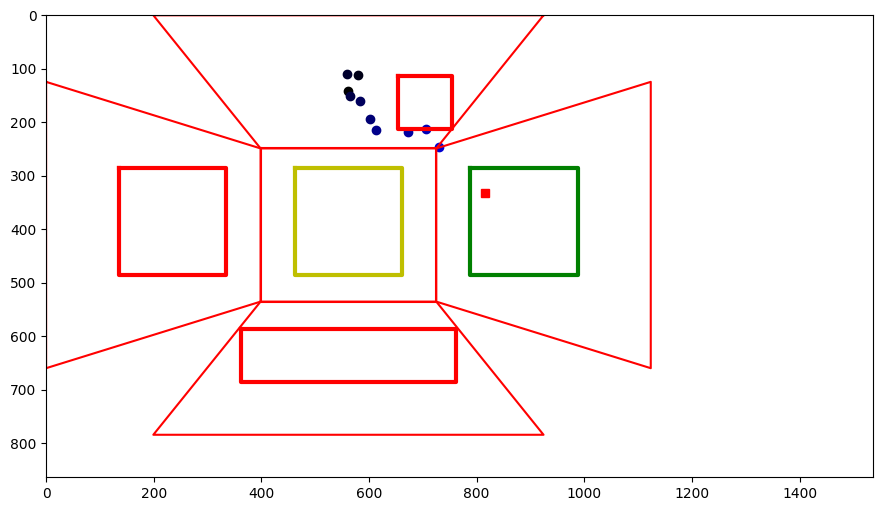

11 unambiguous


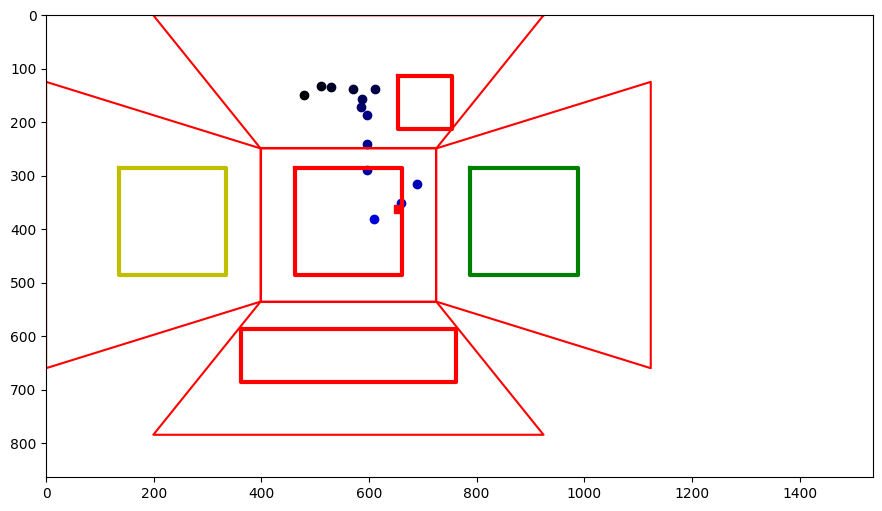

12 simple


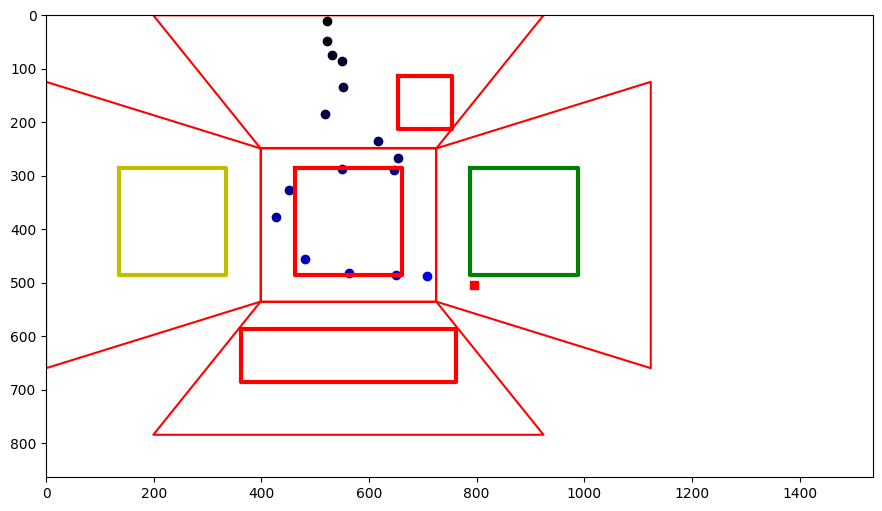

13 complex


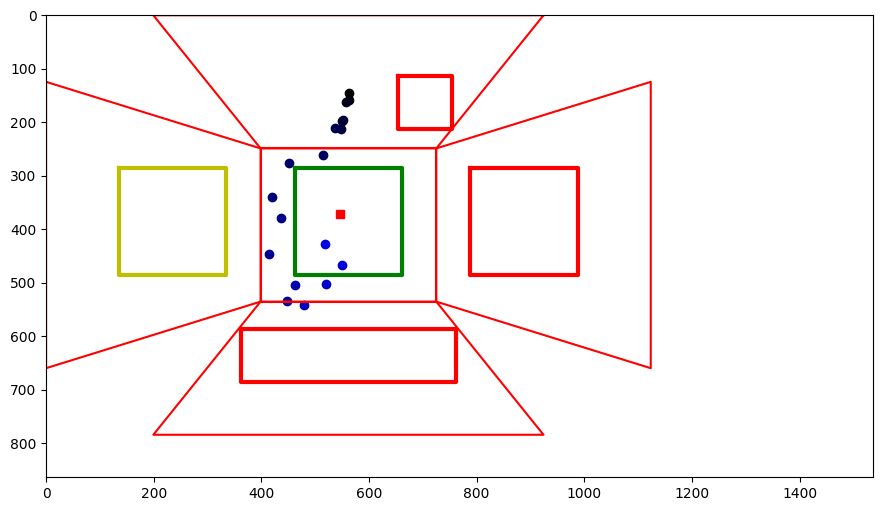

14 complex


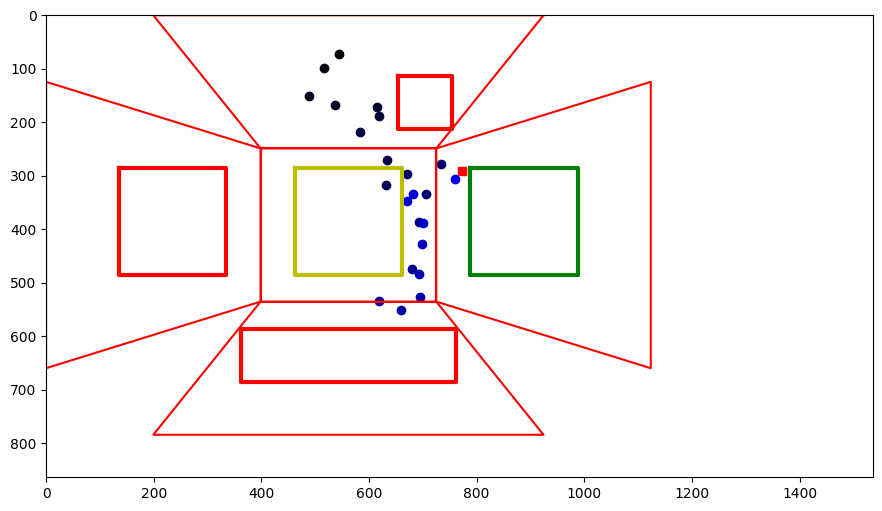

15 simple


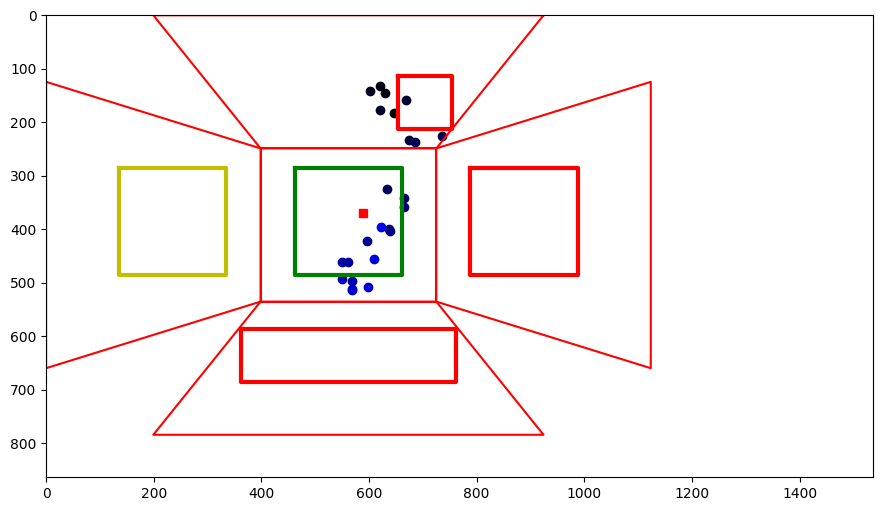

16 simple


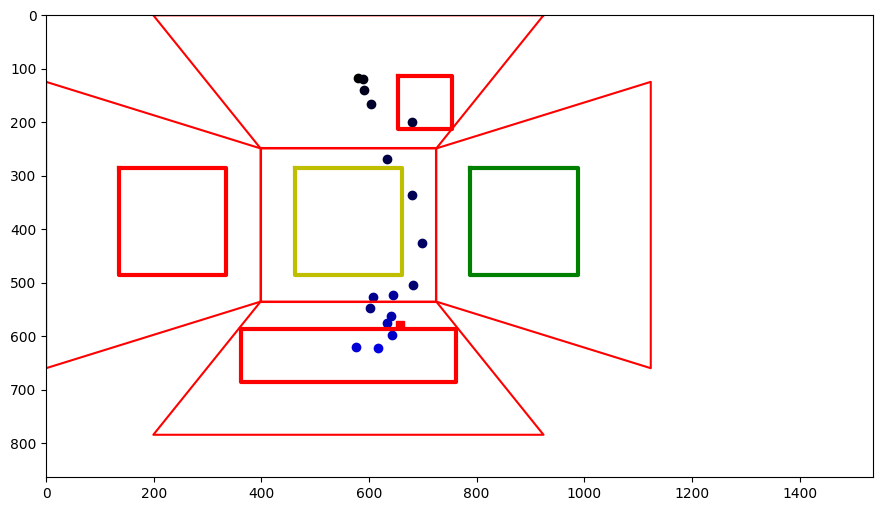

17 unambiguous


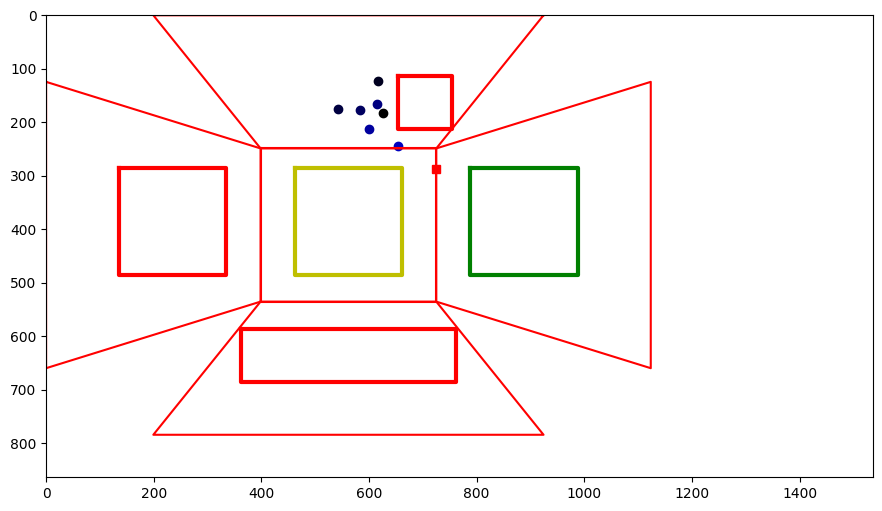

18 simple


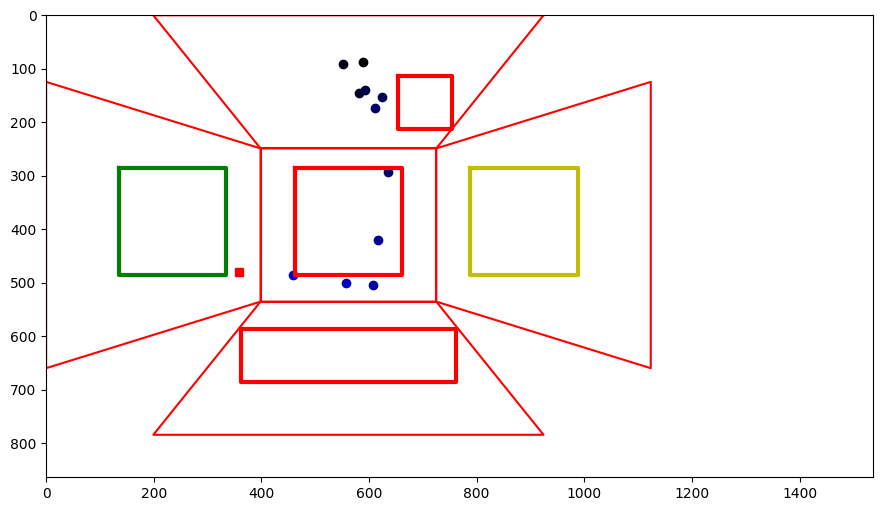

19 complex


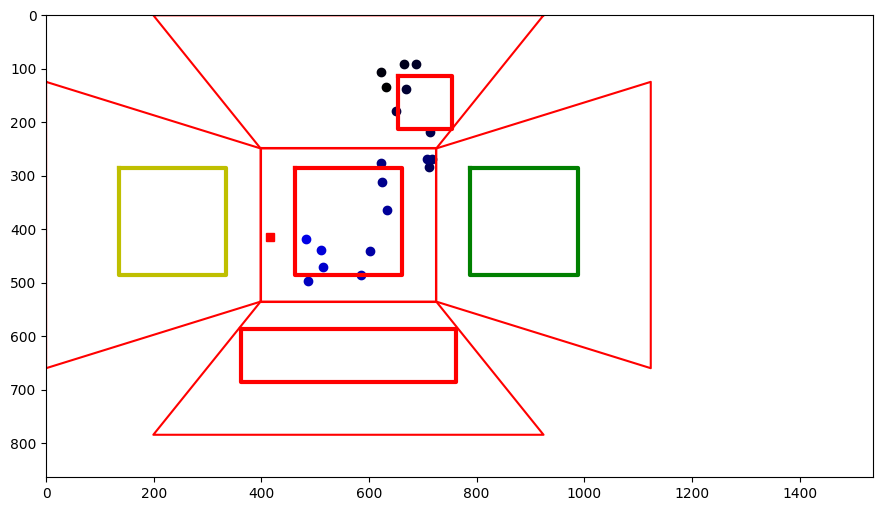

20 complex


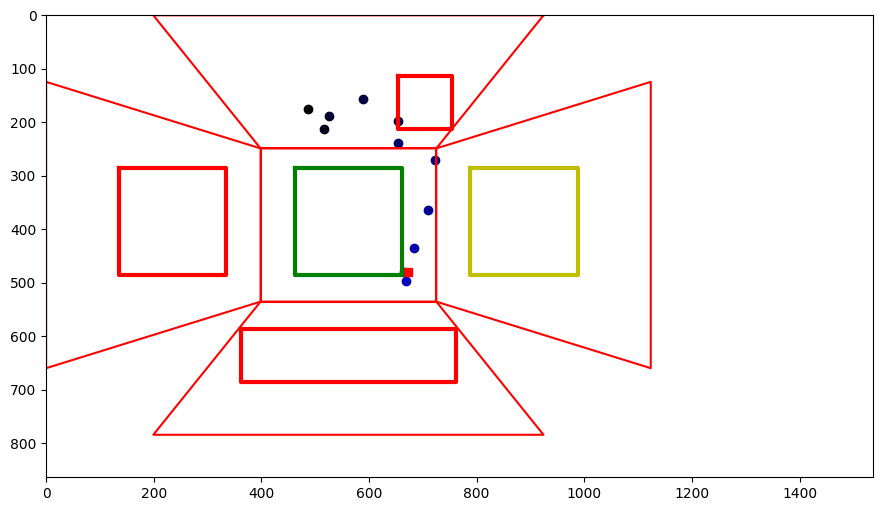

21 complex


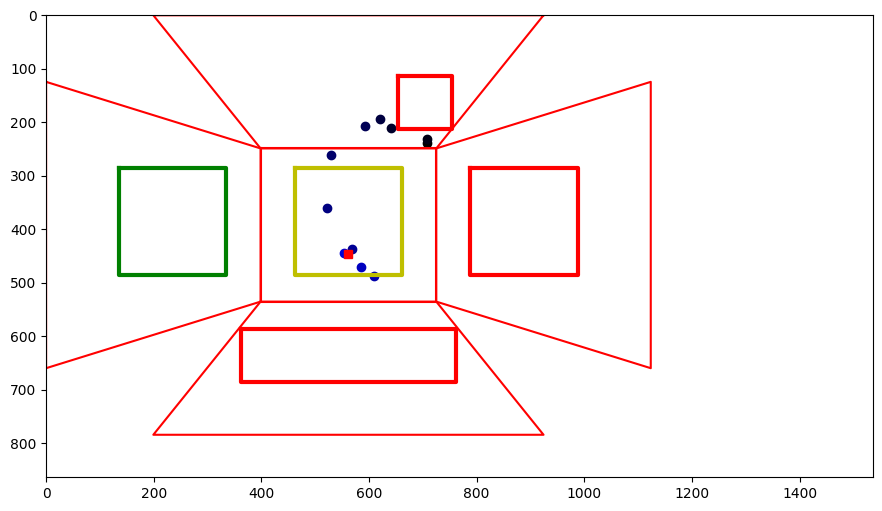

22 unambiguous


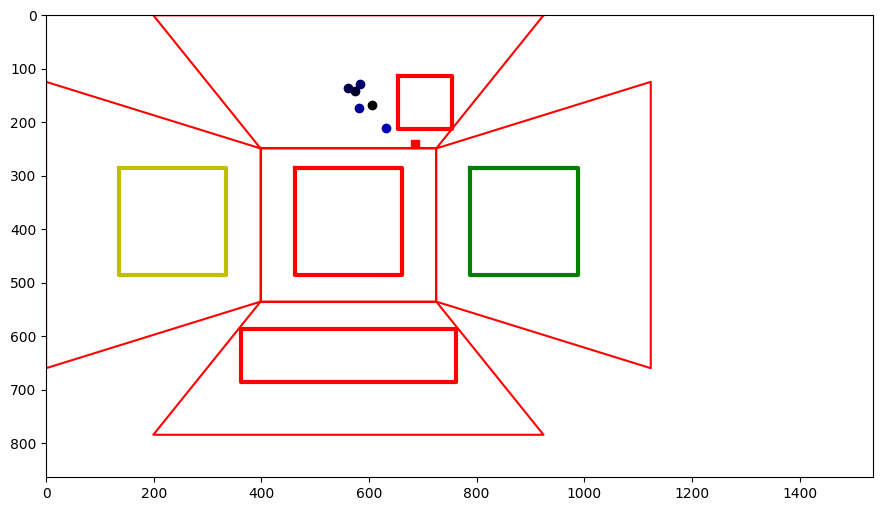

23 unambiguous


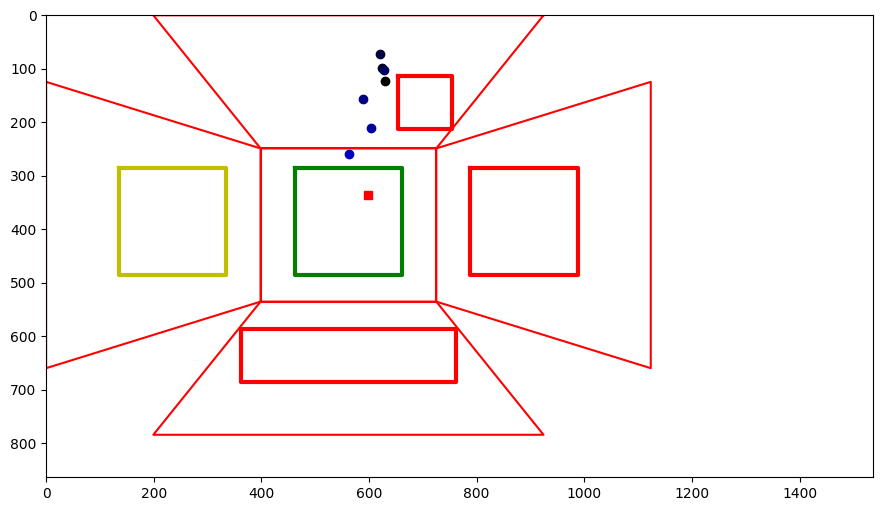

24 simple


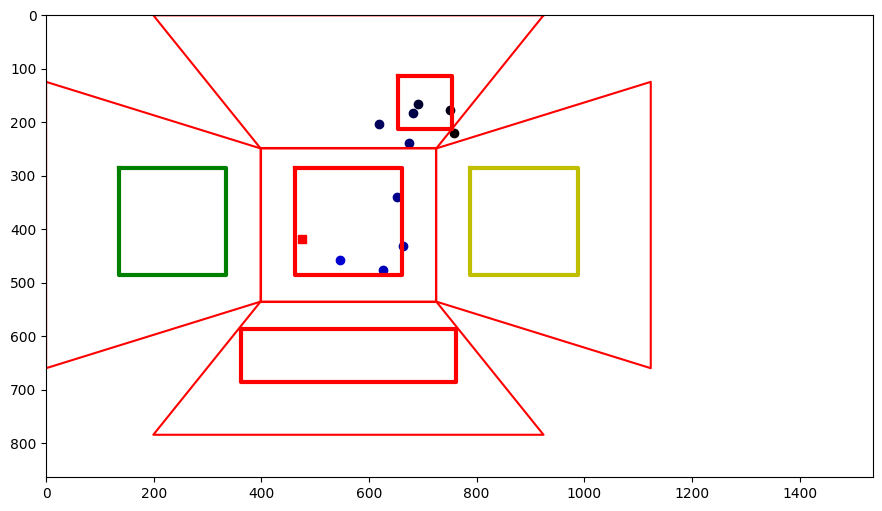

25 unambiguous


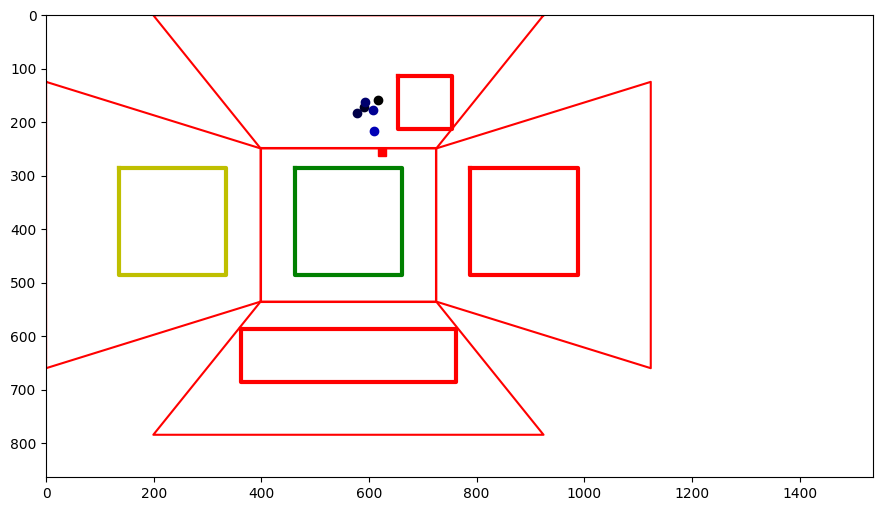

26 simple


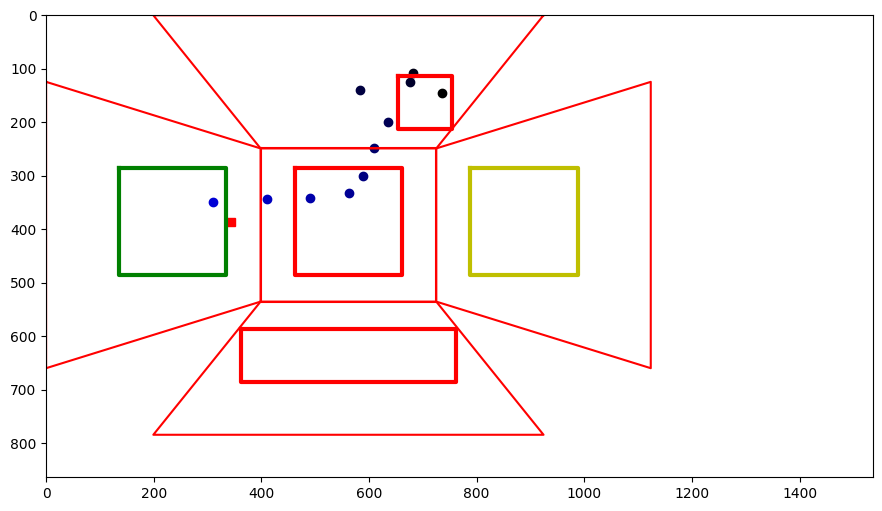

27 simple


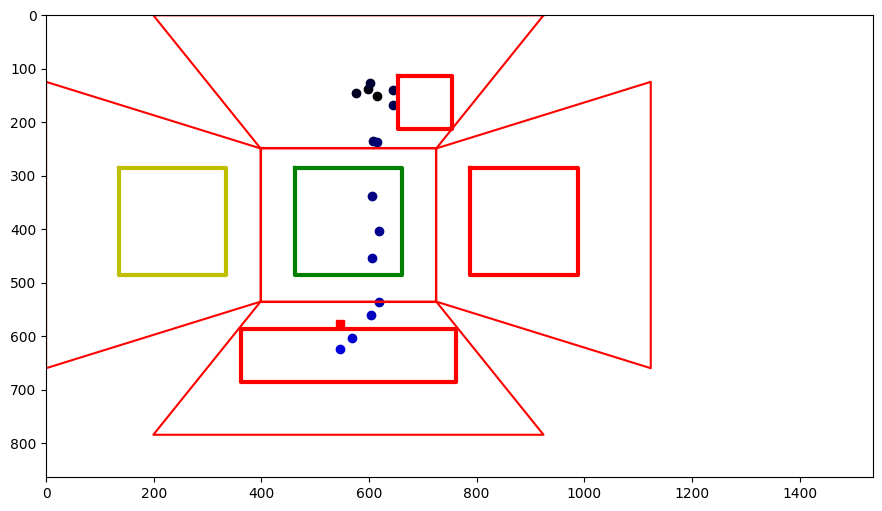

28 simple


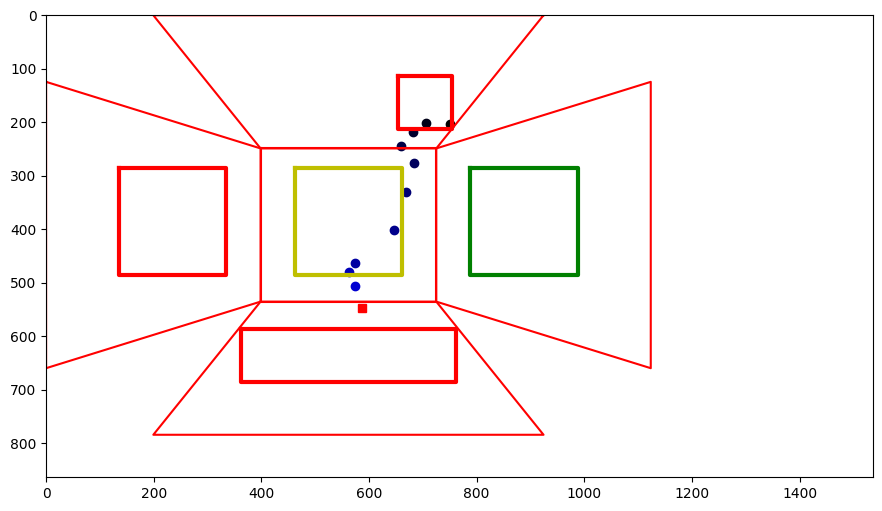

29 complex


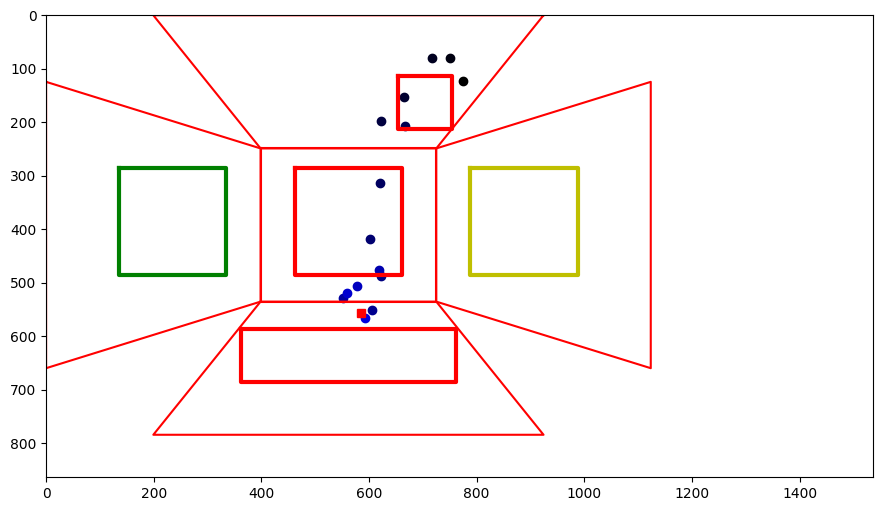

30 unambiguous


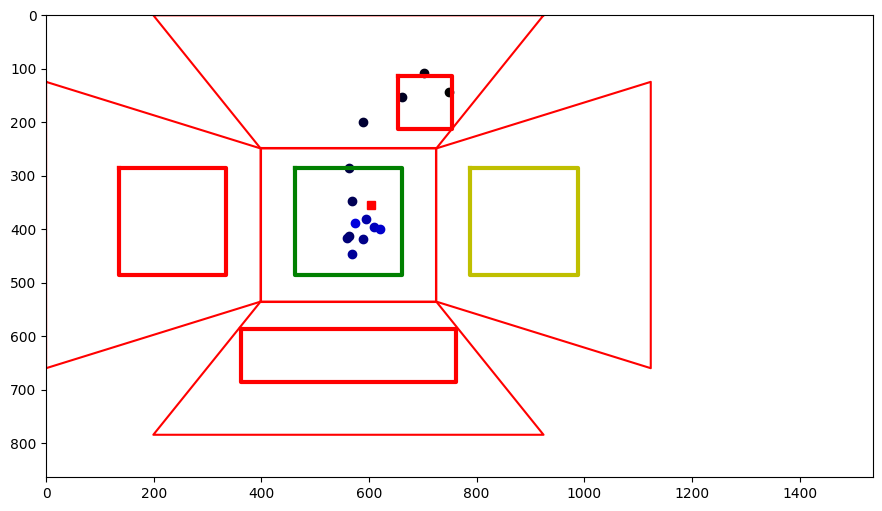

31 complex


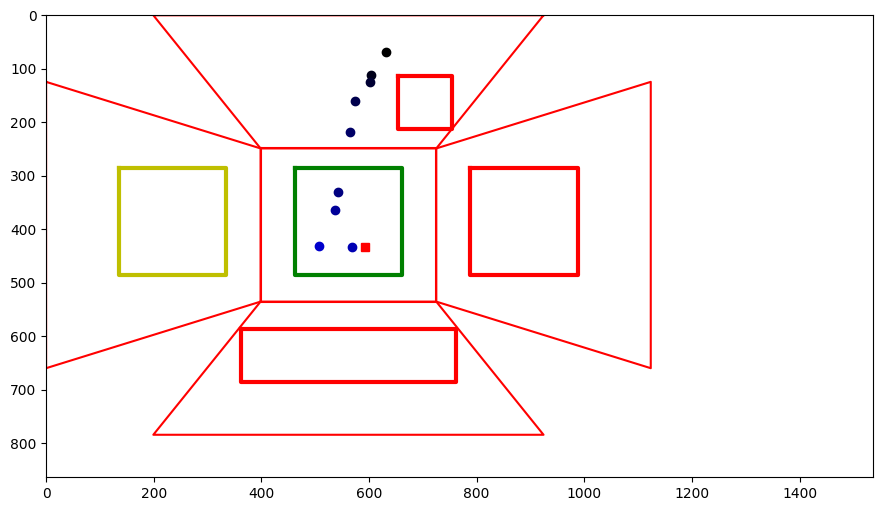

32 complex


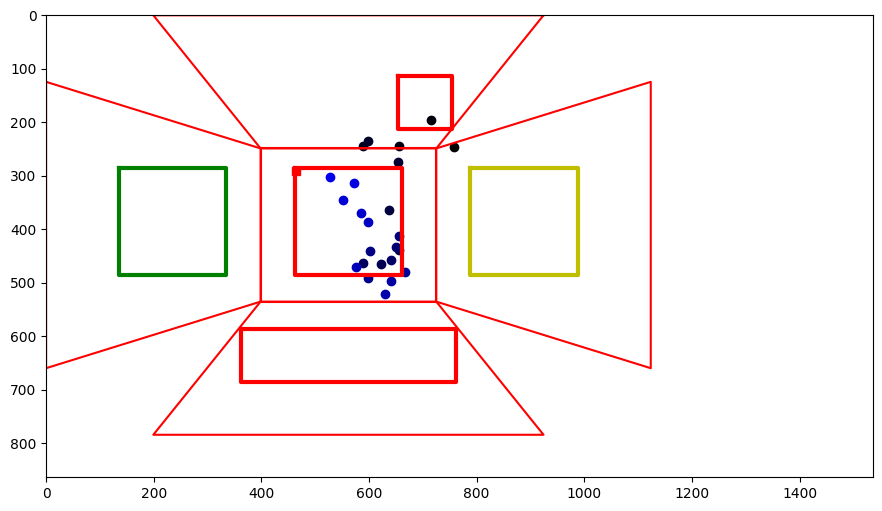

33 unambiguous


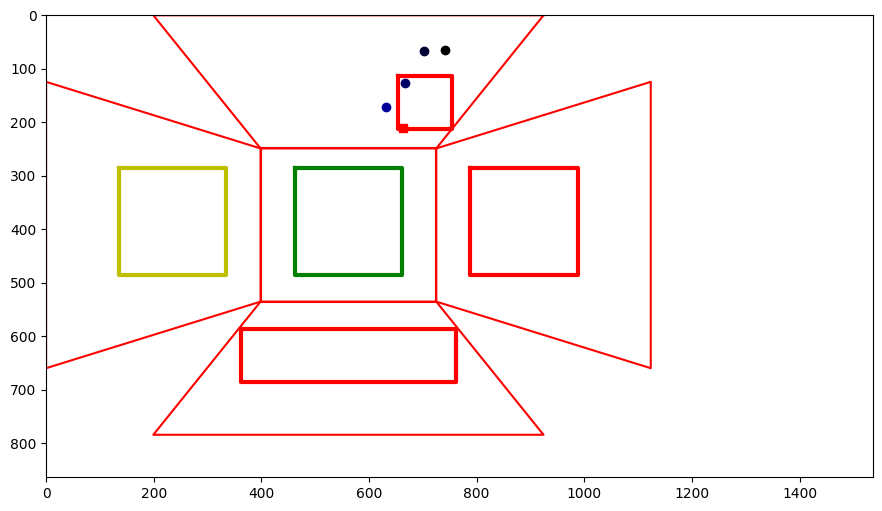

34 complex


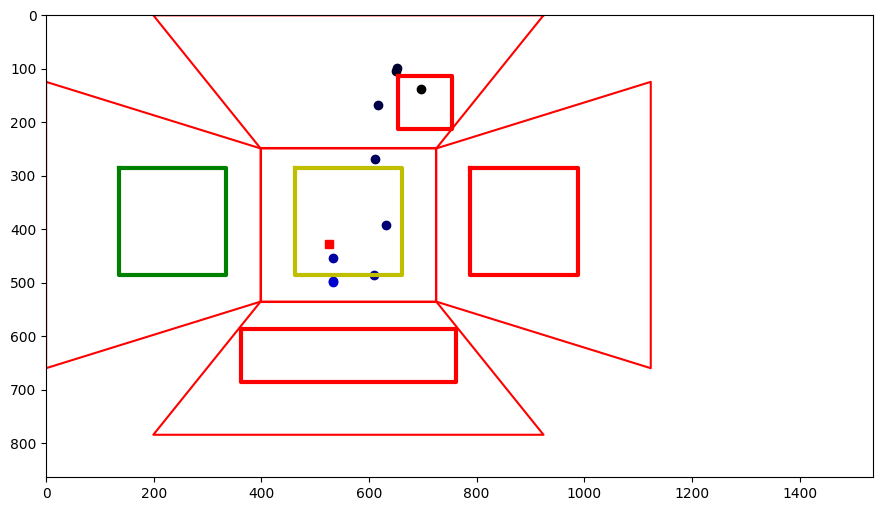

35 simple


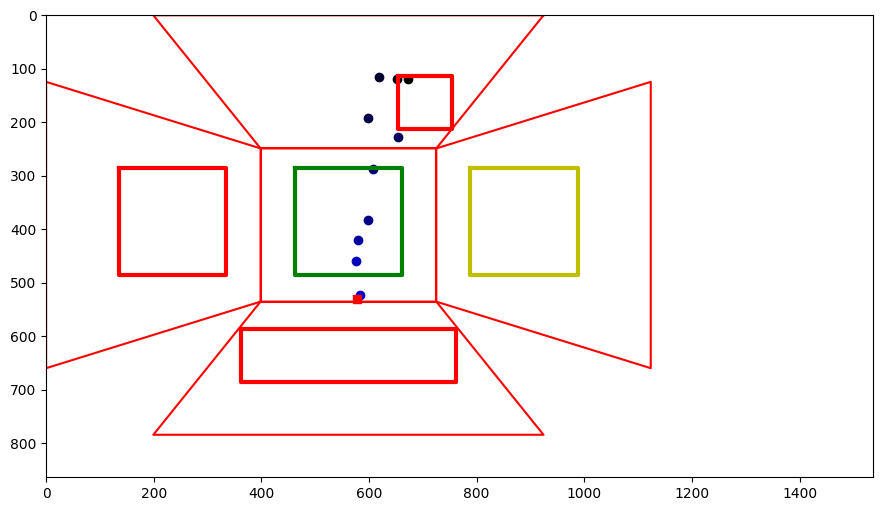

36 strategy_simple


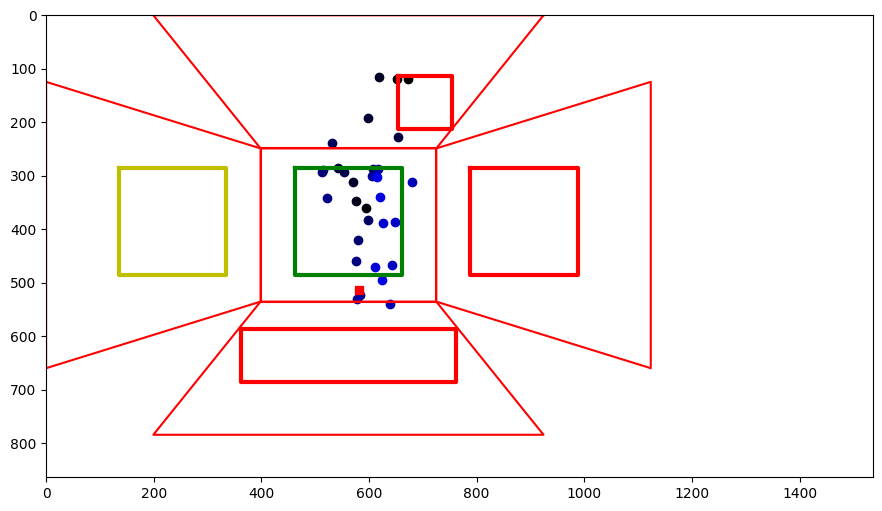

37 strategy_complex


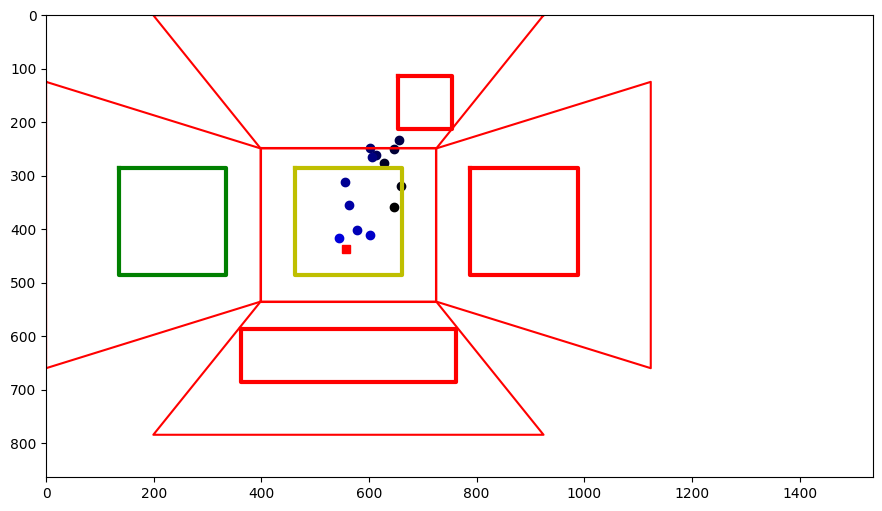

In [43]:
participant = '677dc096791809f5e6c196a9'
print(participant)
sample = df[df['workerid']==participant]
pp.pprint(sample.iloc[0].deviceInfo)
pp.pprint(sample.iloc[0].calibrationPrecision)
resolution = sample.iloc[0].resolution

def plot_polygons(coords, plot):
    aoi = ['sent_msg', 'img1', 'img2', 'img3', 'available_msgs']
    for polygon_type in aoi:
        polygon = compute_polygon(polygon_type, coords)
        x,y = polygon.exterior.xy
        plot.plot(x, y, 'r')
        
aoi = ['img1', 'img2', 'img3', 'sent_msg', 'available_msgs']

for i in range(len(sample)):
    cur_sample = sample.iloc[i]
    gaze_sample = None
    gaze_sample = cur_sample.gaze
    x, y = [], []
    x = np.array([g['x'] for g in gaze_sample.values()])
    y = np.array([g['y'] for g in gaze_sample.values()])
    # print(len(x))
    # print(cur_sample.answerTime)
    print(i, cur_sample.type)
    # make a scatterplot on the left and a heatmap on the right, keep proportions of the screen
    
    # fig, axs = plt.subplots(1, 2, figsize=(2.2*(resolution[0]*6/resolution[1]), 6))
    plt.figure(figsize=(resolution[0]*6/resolution[1], 6))

    # make every next point slightly hue color on the plot to represent a scanpath
    for i in range(len(x)):
        if i == (len(x)-1):
            plt.plot(x[i], y[i], color=(1, 0, 0), marker='s')
        else:
            plt.plot(x[i], y[i], color=(0, 0, i/len(x)), marker='o')


    plt.xlim(0, resolution[0])
    plt.ylim(0, resolution[1])
    plt.gca().invert_yaxis()


    plot_polygons(cur_sample.coordinates, plt)
    for i, area in enumerate(aoi):
        cur_coords = cur_sample.coordinates[area]
        x_min = max(0, cur_coords['x'])
        x_max = cur_coords['x'] + cur_coords['width']
        y_min = max(0, cur_coords['y'])
        y_max = cur_coords['y'] + cur_coords['height']
        # plot boxes around AOI
        color = 'r'
        if cur_sample.trgtPos == i:
            color = 'g'
        if cur_sample.compPos == i:
            color = 'y'
        plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], color=color, linewidth=3)

    plt.show()

